QLBM algorithm solving diffusion equation using D1Q3 scheme (Section IV-B)

In [283]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, QuantumRegister, AncillaRegister, execute
from qiskit.circuit.library import Permutation
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector, StabilizerState, Clifford
from qiskit.visualization import array_to_latex, plot_histogram, plot_bloch_multivector
from qiskit.result import marginal_counts
import time, math
from math import pi, sqrt
from qiskit.providers.aer import AerSimulator
import pickle
from sklearn.metrics import mean_squared_error
from collections import Counter
import scipy.io as spio
import qiskit.result
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from qiskit import BasicAer

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib

plt.rc('axes', labelsize=9.)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=9.)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9.)    # fontsize of the tick labels
plt.rc('legend', fontsize=9.)    # fontsize of the tick labels
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)


Constants definition 

In [284]:
# D1Q3 lattice constants
D = 1/9    #diffusion constant
w = np.array([1/6, 2/3, 1/6]) # weight coeffecients
cx = np.array([1, 0, -1])   #lattice velocities
csq = 1/3   #square of sound speed
ux = 0.  # advection x-velocity

Functions

In [285]:
def compute_feq(rho, w, cx, ux, csq):
    feq = np.zeros((3,M))
    for i in range(3):
        feq[i] = w[i] * (1 + cx[i]*ux/csq) * rho
    return feq

def ini(x, w, cx, ux, csq):
    M = len(x)
    rho = np.zeros(M)    #Delta function as initial density
    rho[mu0] = 1
    feq = compute_feq(rho, w, cx, ux, csq)
    f = feq
    return f, rho

def update_encoding(qc, f, M):
    for k in range(M): 
        amp000 = np.sqrt( (1-f[0][k]) * (1-f[1][k])* (1-f[2][k]) )
        amp100 = np.sqrt( (1-f[1][k]) * (1-f[2][k]) * f[0][k] )
        amp010 = np.sqrt( (1-f[0][k]) * (1-f[2][k]) * f[1][k] )        
        amp001 = np.sqrt( (1-f[0][k]) * (1-f[1][k]) * f[2][k] )
        amp011 = np.sqrt( (1-f[0][k]) * f[1][k] * f[2][k] )
        amp101 = np.sqrt( (1-f[1][k]) * f[0][k] * f[2][k] )
        amp110 = np.sqrt( (1-f[2][k]) * f[0][k] * f[1][k] )
        amp111 = np.sqrt( f[0][k] * f[1][k] * f[2][k] )
        vector = np.array([amp111, amp110, amp101, amp011, amp001, amp010, amp100, amp000])
        qc.prepare_state(vector, [0+3*k, 1+3*k, 2+3*k])  
    return qc



U = [[0, 0, 0, 0, 0, 0, 0, 1],
     [0, 0, 0, 0, 1j/sqrt(3), np.exp(-1j*pi/6)/sqrt(3), np.exp(-1j*pi/6)/sqrt(3), 0],
     [0, 0, 0, 0, np.exp(-1j*pi/6)/sqrt(3), 1j/sqrt(3), np.exp(-1j*pi/6)/sqrt(3), 0],
     [0, np.exp(-1j*pi/6)/sqrt(3), np.exp(-1j*pi/6)/sqrt(3), 1j/sqrt(3), 0, 0, 0, 0],
     [0, 0, 0, 0, np.exp(-1j*pi/6)/sqrt(3), np.exp(-1j*pi/6)/sqrt(3), 1j/sqrt(3), 0],
     [0, np.exp(-1j*pi/6)/sqrt(3), 1j/sqrt(3), np.exp(-1j*pi/6)/sqrt(3), 0, 0, 0, 0],
     [0, 1j/sqrt(3), np.exp(-1j*pi/6)/sqrt(3), np.exp(-1j*pi/6)/sqrt(3), 0, 0, 0, 0],
     [1, 0, 0, 0, 0, 0, 0, 0]]


def collision_Diffusion(circ, k):
    circ.unitary(U, [0+3*k,1+3*k,2+3*k])
    return circ

def computeStreamingPattern(n):
    if (n >= 6):  #minimum for streaming is 2 sites, corresonding to 6qubits
        #first pair of qubits
        streamingPattern = [n-3, 1, 5]
        for i in range(3,n-4):
            if i%3 == 0:  
                streamingPattern.extend([i-3, i+1, i+5])
        #last pair of qubits
        streamingPattern.extend([n-6, n-2, 2])
    else:
        streamingPattern = []
    return streamingPattern

def classical_streaming(M, qubit_counts, numberOfShots):
    #read post collision probabilities
    f = np.zeros((3,M))
    fout = np.zeros((3,M))
    for k in range(M):
        if '1' in qubit_counts[2+3*k]:
            fout[0][k] = qubit_counts[2+3*k]['1'] / numberOfShots
        if '1' in qubit_counts[1+3*k]:
            fout[1][k] = qubit_counts[1+3*k]['1'] / numberOfShots
        if '1' in qubit_counts[0+3*k]:
            fout[2][k] = qubit_counts[0+3*k]['1'] / numberOfShots
    
    # classical streaming
    for k in range(1,M):    #right 
        f[0][k] = fout[0][k-1]

    for k in range(M):     #stationary 
        f[1][k] = fout[1][k] 
        
    for k in range(M-1):     #left
        f[2][k] = fout[2][k+1]

    #periodic BC
    f[0][0] = f[0][M-1]
    f[2][M-1] = f[2][0]

    return f

One time step of QLBM with classical streaming (Section IV-B)

In [286]:
def oneTimeStep_classicalStreaming(f, M, numberOfShots, backend):
    qc = QuantumCircuit(3*M)
    #step1: encoding
    qc = update_encoding(qc, f, M)
    qc.barrier()
    
    #step2: collision
    for k in range(M):
        qc = collision_Diffusion(qc, k)
        
    #step3: measurement
    qc.measure_all()
    result = execute(qc, backend, shots=numberOfShots).result()
    counts = result.get_counts(0)
    qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3*M)]

    #step4: streaming
    f = classical_streaming(M, qubit_counts, numberOfShots)
    return f, qc

One time step of QLBM with quantum streaming (Section IV-B)

In [287]:
def oneTimeStep_quantumStreaming(f, M, numberOfShots, backend, t, maxT):
    qc = QuantumCircuit(3*M)
    #step1: encoding
    qc = update_encoding(qc, f, M)
    qc.barrier()
    
    #step2: collision
    for k in range(M):
        qc = collision_Diffusion(qc, k)
        
    #step3: streaming    
    qc.append(Permutation(num_qubits = n, pattern = computeStreamingPattern(n)), range(n))

    #step4: measurement
    qc.measure_all()
    result = execute(qc, backend, shots=numberOfShots).result()
    counts = result.get_counts(0)
    qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3*M)]
    
    #read post streaming probabilities
    fout = np.zeros((3,M))
    for k in range(M):
        if '1' in qubit_counts[2+3*k]:
            fout[0][k] = qubit_counts[2+3*k]['1'] / numberOfShots
        if '1' in qubit_counts[1+3*k]:
            fout[1][k] = qubit_counts[1+3*k]['1'] / numberOfShots
        if '1' in qubit_counts[0+3*k]:
            fout[2][k] = qubit_counts[0+3*k]['1'] / numberOfShots

    f = fout
    #periodic BC
    f[0][0] = f[0][M-1]
    f[2][M-1] = f[2][0]

    return f, qc

Classical implementation of QLBM algorithm

In [288]:
# number operators
n1 = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0]])

n2 = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0]])

n3 = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0]])


 
# collision operator - Diffusion equation
coeff = np.exp(-1j*pi/6)/sqrt(3)
a = np.exp(1j*pi/6)*sqrt(3)
b = np.exp(1j*2*pi/3)
C_Diffusion = coeff *  np.array([[a, 0, 0, 0, 0, 0, 0, 0],
                                  [0, b, 1, 1, 0, 0, 0, 0],
                                  [0, 1, b, 1, 0, 0, 0, 0],
                                  [0, 1, 1, b, 0, 0, 0, 0],
                                  [0, 0, 0, 0, b, 1, 1, 0],
                                  [0, 0, 0, 0, 1, b, 1, 0],
                                  [0, 0, 0, 0, 1, 1, b, 0],
                                  [0, 0, 0, 0, 0, 0, 0, a]])



def classicalOneTimeStep(f, M):
#     initial combined state
    initial_state = np.zeros((M, 8))
    for i in range(M):
        initial_state[i][0] = np.sqrt( f[0][i] * f[1][i] * f[2][i] )
        initial_state[i][1] = np.sqrt( (1-f[2][i]) * f[0][i]  * f[1][i] )
        initial_state[i][2] = np.sqrt( (1-f[1][i]) * f[0][i]  * f[2][i] )
        initial_state[i][3] = np.sqrt( (1-f[0][i]) * f[2][i]  * f[1][i] )
        initial_state[i][4] = np.sqrt( (1-f[0][i]) * (1-f[1][i]) * f[2][i] )
        initial_state[i][5] = np.sqrt( (1-f[0][i]) * (1-f[2][i]) * f[1][i] )
        initial_state[i][6] = np.sqrt( (1-f[1][i]) * (1-f[2][i]) * f[0][i] )
        initial_state[i][7] = np.sqrt( (1-f[0][i]) * (1-f[1][i]) * (1-f[2][i]) )
        
#     post-collision state (8xlattice_sites)
    post_collision_state = C_Diffusion.dot(initial_state.conjugate().transpose())
    
   # post-collision distribution
    post_collision_distribution = np.zeros((3, M))
    for i in range(M):
        post_collision_distribution[0][i] = post_collision_state.conjugate().transpose()[i].dot(n1.dot( post_collision_state.transpose()[i]))
        post_collision_distribution[1][i] = post_collision_state.conjugate().transpose()[i].dot(n2.dot( post_collision_state.transpose()[i]))
        post_collision_distribution[2][i] = post_collision_state.conjugate().transpose()[i].dot(n3.dot( post_collision_state.transpose()[i]))

#     STREAMING STEP 
    f[0][1:M] = post_collision_distribution[0][0:M-1]
    f[1][0:M] = post_collision_distribution[1][0:M]
    f[2][0:M-1] = post_collision_distribution[2][1:M]

#      periodic BC
    f[0][0] = f[0][M-1]
    f[2][M-1] = f[2][0]

    return f

Simulation parameters 

In [289]:
L = 8  # domain length 
M = L+1  # number of lattice sites (from 0 to L)
n = 3*M   # number of qubits
x = np.array(range(M)) # 1D lattice

#initial condition: delta function 
mu0 = int(np.ceil(L/2)) # mean

numberOfShots = 100000  # number of shots
maxT = 3   # number of time steps

# choose simulation backend
backend = 'aer_simulator_matrix_product_state' 
# backend = 'aer_simulator_statevector' 

Main loop

In [290]:
#initialization
fini, rho = ini(x, w, cx, ux, csq)    

# plt.plot(x, rho)

# qc = QuantumCircuit(3*M)
# qc = update_encoding(qc, fini, M)
fq_classical = fini
fq_quantum = fini
fClassical = fini

for t in range(1, maxT+1):
    print('t = ', t)
    #quantum implementation, classical streaming
    fq_classical, qc1 = oneTimeStep_classicalStreaming(fq_classical, M, numberOfShots, Aer.get_backend(backend)) 
    rhoq_classical = fq_classical[0] + fq_classical[1] + fq_classical[2]
    #quantum implementation, quantum streaming
    fq_quantum, qc2 = oneTimeStep_quantumStreaming(fq_quantum, M, numberOfShots, Aer.get_backend(backend), t, maxT)
    rhoq_quantum = fq_quantum[0] + fq_quantum[1] + fq_quantum[2]
    #classical implementation
    fClassical = classicalOneTimeStep(fClassical, M)
    rhoClassical = fClassical[0] + fClassical[1] + fClassical[2]
print('Done')

t =  1


/Users/fatimaezahrachrit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/fatimaezahrachrit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/fatimaezahrachrit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ComplexWarning: Casting complex values to real discards the imaginary part


t =  2
t =  3
Done


Results output and plot

RMSE of quantum solution with classical streaming:
 0.0008052964422094155
RMSE of quantum solution with quantum streaming:
 0.0007936607162014116


Text(0, 0.5, 'Density')

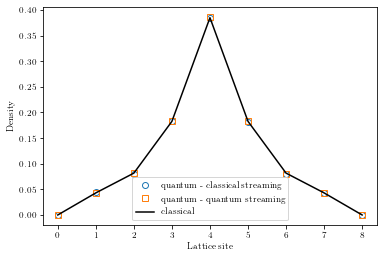

In [291]:
MSE = mean_squared_error(rhoClassical, rhoq_classical)
RMSE = math.sqrt(MSE)
print("RMSE of quantum solution with classical streaming:\n", RMSE)

MSE = mean_squared_error(rhoClassical, rhoq_quantum)
RMSE = math.sqrt(MSE)
print("RMSE of quantum solution with quantum streaming:\n", RMSE)

plt.plot(x, rhoq_classical,'o', markersize = 6, markerfacecolor='none')
plt.plot(x, rhoq_quantum,'s', markersize = 6, markerfacecolor='none')
plt.plot(x, rhoClassical, 'k')
plt.legend(['quantum - classical streaming', 'quantum - quantum streaming', 'classical']) 
plt.xlabel('Lattice site')
plt.ylabel('Density')